In [1]:
# use cv2 version ==> opencv-python==3.4.2.17

from numpy import linalg as LA
import numpy as np
import cv2
from rectify import rectify
import matplotlib.pyplot as plt


In [2]:
# function to visualize the given input images
def vis_imgs(left,right):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.subplot(121)
    plt.imshow(left)
    plt.subplot(122)
    plt.imshow(right)
    plt.show()

In [11]:
# match function
def match(left, right, patch, search_range, metric, sii=0.1):
    """  
    Assume both left and right images have same dimensions
    :type left: OpenCv Image
    """

    left = cv2.resize(left, None, fx=sii, fy=sii)
    right = cv2.resize(right, None, fx=sii, fy=sii)
    w, h = left.shape[0:2]

    disparity = np.zeros((w, h), np.uint8)
    disparity.shape = w, h
    patch_half = int(patch / 2)

    offset_adjust = 255/search_range

    for y in range(patch_half, w - patch_half - 1):
        for x in range(patch_half, h - patch_half - 1):
            best_match = 0
            if metric == 'ssd':
                best_score = 65534
                for search in range(search_range):
                    score = 0
                    for i in range(-patch_half, patch_half):
                        for j in range(-patch_half, patch_half):
                            ssd_t = int(left[y + i, x + j]) - int((right[y + i, (x + j) - search]))
                            score += ssd_t * ssd_t  # SSD
                    if score < best_score:
                        best_score = score
                        best_match = search
            
            elif metric == 'sad':
                best_score = 65534
                for search in range(search_range):
                    score = 0
                    for i in range(-patch_half, patch_half):
                        for j in range(-patch_half, patch_half):
                            a1,a2 = np.zeros(3), np.zeros(3)
                            a1, a2 = left[y+i, x+j], right[y+i,(x+j)-search]
                            ssd_t = LA.norm(a1.astype('float')-a2.astype('float'))
                            score += abs(ssd_t)  # SSD
                    if score < best_score:
                        best_score = score
                        best_match = search
                        
            elif metric == 'ncc':
                left_patch = left[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
                left_mu = np.mean(left_patch)
                left_sigma = np.std(left_patch)
                best_score = -1
                for search in range(search_range):
                    if x + search + patch_half < h + 1:
                        right_patch = right[y - patch_half:y + patch_half,
                                      x + search - patch_half:(x + search + patch_half)]
                        right_mu = np.mean(right_patch)
                        right_sigma = np.std(right_patch)
                        num = np.mean((left_patch - left_mu) * (right_patch - right_mu))
                        denom = left_sigma * right_sigma
                        score = num / denom
                    if score > best_score:
                        best_score = score
                        best_match = search

            elif metric == 'cosine':
                left_patch = left[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
                best_score = 0
                for search in range(search_range):
                    if x + search + patch_half < h + 1:

                        left_flatten = left_patch.flatten()[0]
                        right_patch = right[y - patch_half:y + patch_half,
                                      x + search - patch_half:(x + search + patch_half)]
                        right_flatten = right_patch.flatten()[0]
                        dot = np.dot(left_flatten, right_flatten)
                        left_magnitude = np.linalg.norm(left_flatten)
                        right_magnitude = np.linalg.norm(right_flatten)
                        score = dot / (left_magnitude * right_magnitude)
                    if score > best_score:
                        best_score = score
                        best_match = search
            disparity[y, x] =  offset_adjust*best_match

    return disparity



In [16]:
def find_depth_images(left,right,metric,sii=0.1):
    patch_size = [4,6,8]
    search_range = [15,25,40]
    plt.rcParams["figure.figsize"] = (20,20)

    for i in range(len(patch_size)):
        ps = patch_size[i]
        for j in range(len(search_range)):
            print(i,j,end='    ')
            sr = search_range[j]
            dep_img = match(left, right, ps, sr, metric, sii)
            plt.subplot(len(patch_size),len(search_range),i*len(search_range)+j+1)
            plt.imshow(dep_img)
    plt.show()

In [17]:
metrics = ['sad']

In [18]:
def read_image(location):
    image = cv2.imread(location)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

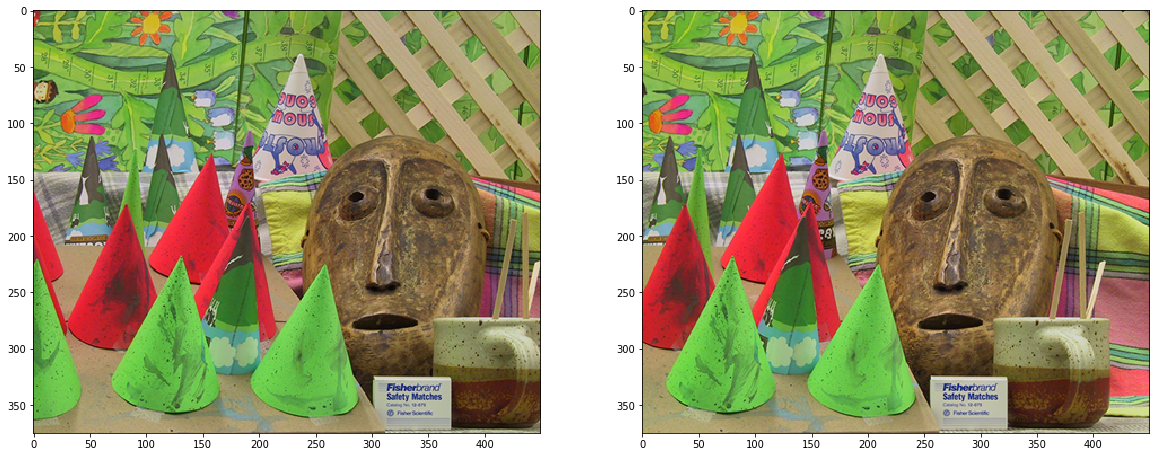

0 0    0 1    

In [ ]:
left = read_image('data/cone1.png')
right = read_image('data/cone2.png')
vis_imgs(left,right)
for m in metrics:
    find_depth_images(left,right,m,0.5)

In [ ]:
left = read_image('data/room1.png')
right = read_image('data/room2.png')
vis_imgs(left,right)
for m in metrics:
    find_depth_images(left,right,m,0.5)

In [ ]:
left = read_image('data/teddy1.png')
right = read_image('data/teddy2.png')
vis_imgs(left,right)
for m in metrics:
    find_depth_images(left,right,m,0.5)